# Training a multi-modal model

This notebook trains a model which handles both numeric data and visual data (images).

In [1]:
# Reload imported code automatically.
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import gc
import os
import sys
from typing import List

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

sys.path.append("..")
from src import simplemodel, training, utils, visualmodel
from src.training import Vocabulary

In [3]:
matplotlib.rc("font", **{"size": 14})

## Parameters

In [4]:
# Data parameters.
DF_PATH = os.path.join("..", "data", "carsWithImageCleaned.csv")
# IMAGE_DIR = os.path.join("..", "data", "autovit_images")
IMAGE_DIR = os.path.join("..", "data", "small_images")
MODEL_NAME = "visualmodel"
HELPER_FILENAME = f"{MODEL_NAME}-helper.pkl"

IMAGE_SIZE = 128          # Images get cropped to this dimension.
LOAD_IMAGES_IN_MEM = True # Pre-load all cropped images into memory (uses more RAM, but training should be faster).

# Model parameters.
COLS_TO_SCALE = ["Anul", "Km", "Putere (CP)", "Capacitate cilindrica (cm3)", "Numar de portiere", "Consum (l/100km)"]
COLS_NORMAL = ["Fara accident in istoric", "Carte de service", "Filtru de particule", "Inmatriculat", "Primul proprietar"]
COLS_TO_EMBED = ["Marca", "Model", "Combustibil", "Cutie de viteze", "Tip Caroserie", "Culoare", "Tractiune"]
EMBEDDING_DIM = 4
HIDDEN_SIZES = [113, 25]

# Training parameters.
BATCH_SIZE = 128
EPOCHS = 12
LEARNING_RATE = 0.01
TRAIN_SIZE = 0.66

# Miscellaneous.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {DEVICE}")
TORCH_SEED = 13
torch.manual_seed(TORCH_SEED)

Using device cuda


## Loading and preparing the data

In [5]:
df = pd.read_csv(DF_PATH, index_col=0)

# Remove cars which are outliers when considering their price.
df = df.drop(df[~utils.inlier_mask(df["Pret (EUR)"])].index)

print(f"Using {len(df)} samples")
df.head()

Using 10985 samples


,Url,Autovit Id,Pret (EUR),Oferit de,Categorie,Marca,Model,Anul,Km,Combustibil,...,Tip Caroserie,Numar de portiere,Culoare,Fara accident in istoric,Carte de service,Tractiune,Filtru de particule,Inmatriculat,Primul proprietar,Consum (l/100km)
0,https://www.autovit.ro/anunt/suzuki-vitara-1-6...,7049990250,16999.0,Proprietar,Autoturisme,Suzuki,Vitara,2018,26000,Benzina,...,SUV,5,Negru,True,True,Nu e mentionat,False,False,False,5.8
1,https://www.autovit.ro/anunt/toyota-auris-1-8-...,7049960669,12500.0,Proprietar,Autoturisme,Toyota,Auris,2015,239465,Hibrid,...,Combi,5,Gri,True,True,Nu e mentionat,False,False,False,3.5
2,https://www.autovit.ro/anunt/skoda-octavia-1-6...,7049895868,14994.0,Firma,Autoturisme,Skoda,Octavia,2020,100000,Diesel,...,Sedan,5,Albastru,True,True,Fata,True,True,True,4.7
3,https://www.autovit.ro/anunt/ford-focus-1-6-td...,7049990021,5000.0,Proprietar,Autoturisme,Ford,Focus,2012,245000,Diesel,...,Combi,5,Alb,True,True,Fata,True,True,False,5.1
4,https://www.autovit.ro/anunt/opel-insignia-ID7...,7049990234,17800.0,Proprietar,Autoturisme,Opel,Insignia,2017,65000,Diesel,...,Sedan,4,Alb,True,False,Fata,False,True,False,4.7


In [6]:
class DatasetWithImages(Dataset):
    """A dataset which combines all inputs taken by the model."""

    def __init__(self, df: pd.DataFrame, image_dir: str, input_helper: simplemodel.InputHelper):
        self.df = df.copy()
        self.image_dir = image_dir
        self.input_helper = input_helper

        self.image_transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize(IMAGE_SIZE),
            torchvision.transforms.CenterCrop(IMAGE_SIZE),
            torchvision.transforms.ToTensor(),
        ])

        if LOAD_IMAGES_IN_MEM:
            self.processed_images = {
                id: self.process_image(self.get_image(id))
                for id in df["Autovit Id"]
            }

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        slice = self.df.iloc[[idx]]

        y_max = self.input_helper.maxes["Pret (EUR)"]
        y = torch.tensor(row["Pret (EUR)"] / y_max)

        if LOAD_IMAGES_IN_MEM:
            image = self.processed_images[row["Autovit Id"]]
        else:
            image = self.process_image(self.get_image(row["Autovit Id"]))

        inputs, indices = simplemodel.make_inputs(
            self.input_helper,
            slice[COLS_TO_SCALE],
            slice[COLS_NORMAL],
            slice[COLS_TO_EMBED],
        )
        # The input maker produces a batch of inputs, but `__getitem__` should
        # produce a single data point.
        inputs = inputs.squeeze(0)
        indices = indices.squeeze(0)

        return inputs, indices, image, y

    def process_image(self, image: Image) -> torch.Tensor:
        return self.image_transforms(image)

    def get_image(self, autovit_id: int) -> Image:
        id = str(autovit_id)
        path = os.path.join(self.image_dir, id, f"{id}.webp")
        image = Image.open(path)
        return image

Form the train/validation datasets.

In [7]:
df_train, df_valid = train_test_split(df, train_size=TRAIN_SIZE, random_state=TORCH_SEED)
print(f"Training set shape:   {df_train.shape}")
print(f"Validation set shape: {df_valid.shape}")

Training set shape:   (7250, 23)
Validation set shape: (3735, 23)


In [8]:
input_helper = simplemodel.make_input_helper(
    df_train[COLS_TO_SCALE + ["Pret (EUR)"]],
    df_train[COLS_TO_EMBED]
)

Build batched dataloaders to iterate easily through the dataset.

In [9]:
dataset_train = DatasetWithImages(df_train, IMAGE_DIR, input_helper)
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE)

dataset_valid = DatasetWithImages(df_valid, IMAGE_DIR, input_helper)
loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=BATCH_SIZE)

## Training a model

In [10]:
def custom_loss(pred: torch.Tensor, real: torch.Tensor) -> torch.Tensor:
    """
    Compute the mean absolute (real) difference between predicted and real
    prices.
    """
    scale_coeff = input_helper.maxes["Pret (EUR)"]
    diffs = pred * scale_coeff - real * scale_coeff
    return diffs.abs().mean()

In [11]:
input_size = next(iter(loader_train))[0].shape[1]
model = visualmodel.VisualModel(
    input_size=input_size,
    vocab_lens=[len(input_helper.vocabs[col]) for col in COLS_TO_EMBED],
    embedding_dim=EMBEDDING_DIM,
    hidden_sizes=HIDDEN_SIZES,
)
model.to(DEVICE)

# loss_function = nn.MSELoss()
# loss_function = nn.HuberLoss()
loss_function = custom_loss
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

model

VisualModel(
  (conv): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=28800, out_features=10, bias=True)
    (4): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout1d(p=0.5, inplace=False)
  )
  (embeddings): ModuleList(
    (0): Embedding(52, 4, max_norm=1)
    (1): Embedding(425, 4, max_norm=1)
    (2): Embedding(4, 4, max_norm=1)

In [12]:
%%time

training_info = pd.DataFrame(columns=["epoch", "loss"])
best_model_state = None

for epoch in range(EPOCHS):

    loss_train = 0
    model.train()
    for x_inputs, x_indices, x_images, y in loader_train:
        x_inputs, x_indices, x_images, y = x_inputs.to(DEVICE), x_indices.to(DEVICE), x_images.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x_inputs, x_indices, x_images).view(-1)
        loss = loss_function(out, y)
        loss.backward()
        optimizer.step()
        loss_train += loss.item()

        # Purge the current batch to avoid running out of CUDA memory.
        del x_inputs, x_indices, x_images, y, out, loss
        gc.collect()
        torch.cuda.empty_cache()

    loss_valid = 0
    model.eval()
    with torch.no_grad():
        for x_inputs, x_indices, x_images, y in loader_valid:
            x_inputs, x_indices,x_images, y = x_inputs.to(DEVICE), x_indices.to(DEVICE), x_images.to(DEVICE), y.to(DEVICE)
            out = model(x_inputs, x_indices, x_images).view(-1)
            loss = loss_function(out, y)
            loss_valid += loss.item()
            del x_inputs, x_indices, x_images, y, out, loss
            gc.collect()
            torch.cuda.empty_cache()

    training_info = pd.concat([training_info, pd.DataFrame([{
        "epoch": epoch,
        "loss_train": loss_train,
        "mean_loss_train": loss_train / len(loader_train),
        "loss_valid": loss_valid,
        "mean_loss_valid": loss_valid / len(loader_valid),
    }])])

    print(
        f"Epoch {epoch}:" +
        f"\tmean train loss: {loss_train/len(loader_train):.5f}  (total {loss_train:.5f})" +
        f"\tmean valid loss: {loss_valid/len(loader_valid):.5f}  (total {loss_valid:.5f})"
    )

    if loss_valid == training_info.loss_valid.min():
        best_model_state = copy.deepcopy(model.state_dict())

if best_model_state is not None:
    print(f"Loading state with valid loss: {training_info.loss_valid.min():.5f}")
    model.load_state_dict(best_model_state)

Epoch 0:	mean train loss: 8620.43658  (total 491364.88525)	mean valid loss: 7307.52638  (total 219225.79144)
Epoch 1:	mean train loss: 5075.37555  (total 289296.40640)	mean valid loss: 5966.15851  (total 178984.75529)
Epoch 2:	mean train loss: 4448.16863  (total 253545.61203)	mean valid loss: 6079.73152  (total 182391.94561)
Epoch 3:	mean train loss: 4232.04802  (total 241226.73722)	mean valid loss: 5036.70515  (total 151101.15441)
Epoch 4:	mean train loss: 4007.89771  (total 228450.16929)	mean valid loss: 4761.68811  (total 142850.64323)
Epoch 5:	mean train loss: 3809.49999  (total 217141.49965)	mean valid loss: 4541.27741  (total 136238.32219)
Epoch 6:	mean train loss: 3708.78571  (total 211400.78544)	mean valid loss: 4663.61069  (total 139908.32077)
Epoch 7:	mean train loss: 3599.64873  (total 205179.97765)	mean valid loss: 5030.64537  (total 150919.36117)
Epoch 8:	mean train loss: 3506.32807  (total 199860.69976)	mean valid loss: 4719.37832  (total 141581.34974)
Epoch 9:	mean train

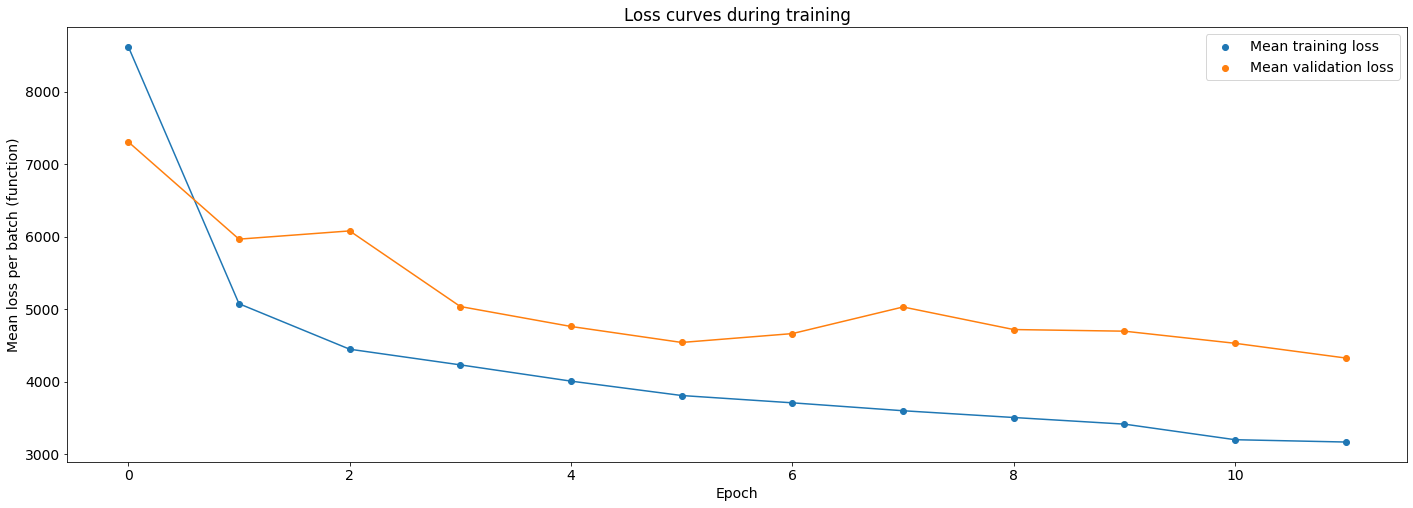

In [13]:
# Plot loss curves.
window = training_info.iloc[:]
plt.figure(figsize=(24, 8))
plt.scatter(data=window, x="epoch", y="mean_loss_train", label="Mean training loss")
plt.plot("epoch", "mean_loss_train", data=window, label="")
plt.scatter(data=window, x="epoch", y="mean_loss_valid", label="Mean validation loss")
plt.plot("epoch", "mean_loss_valid", data=window, label="")
plt.title("Loss curves during training")
plt.xlabel("Epoch")
plt.ylabel(f"Mean loss per batch ({loss_function.__class__.__name__})")
plt.legend()
plt.show()

## Price differences

In [14]:
@torch.no_grad()
def prediction_errors(loader) -> None:
    coeff = input_helper.maxes["Pret (EUR)"]
    diffs = []

    model.eval()
    for inputs, indices, images, prices in loader:
        inputs, indices, images, prices = inputs.to(DEVICE), indices.to(DEVICE), images.to(DEVICE), prices.to(DEVICE)
        predicted = model(inputs, indices, images).view(-1) * coeff
        real = prices.view(-1) * coeff
        diffs.extend((predicted - real).tolist())
        del inputs, indices, images, prices, predicted, real
        gc.collect()
        torch.cuda.empty_cache()

    diffs = torch.tensor(diffs )
    print(f"Mean absolute difference:   {diffs.abs().mean():.5f}")
    print(f"Median absolute difference: {diffs.abs().median():.5f}")
    print()


print("Training set:")
prediction_errors(loader_train)
print("Validation set:")
prediction_errors(loader_valid)

Training set:
Mean absolute difference:   3937.72632
Median absolute difference: 2844.01416

Validation set:
Mean absolute difference:   4321.31738
Median absolute difference: 3096.80688



## Predicting prices for unseen inputs

In [15]:
# Making a prediction for unseen input.
# Real input taken from https://www.autovit.ro/anunt/audi-a5-ID7H7Azi.html.
# The real price is 29 990 EUR.

fictional = pd.DataFrame({
    "Oferit de": "Proprietar",
    "Marca": "Audi",
    "Model": "A5",
    "Anul": 2019,
    "Km": 155_000.0,
    "Combustibil": "Diesel",
    "Putere (CP)": 190,
    "Capacitate cilindrica (cm3)": 1998,
    "Cutie de viteze": "Automata",
    "Tip Caroserie": "Sedan",
    "Numar de portiere": 4,
    "Culoare": "Maro",
    "Fara accident in istoric": True,
    "Carte de service": True,
    "Tractiune": "Fata",
    "Filtru de particule": True,
    "Inmatriculat": False,
    "Primul proprietar": False,
    "Consum (l/100km)": 4.8,
}, index=[0])

fictional_inputs, fictional_indices = simplemodel.make_inputs(
    input_helper,
    cols_to_scale=fictional[COLS_TO_SCALE],
    cols_normal=fictional[COLS_NORMAL],
    cols_to_embed=fictional[COLS_TO_EMBED],
)
fictional_inputs = fictional_inputs.to(DEVICE)
fictional_indices = fictional_indices.to(DEVICE)

# Steal a random image.
fictional_image = next(iter(loader_valid))[2][:1]
fictional_image = fictional_image.to(DEVICE)

model.eval()
with torch.no_grad():
    prediction = model(fictional_inputs, fictional_indices, fictional_image).item()

predicted_price = prediction * input_helper.maxes["Pret (EUR)"]
print(f"Predicted price: {predicted_price}")

Predicted price: 33422.453958296435


## Saving the model

In [16]:
# Save the model from the CPU.
model.cpu()
utils.store_model_weights(model, MODEL_NAME)
utils.store_model_helper(input_helper, HELPER_FILENAME)

# Move the model back to its original device.
model.to(DEVICE);

Saved model state dict to '../models/visualmodel-statedict.pt'
Pickled the object to '../models/visualmodel-helper.pkl'
